In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline

In [2]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


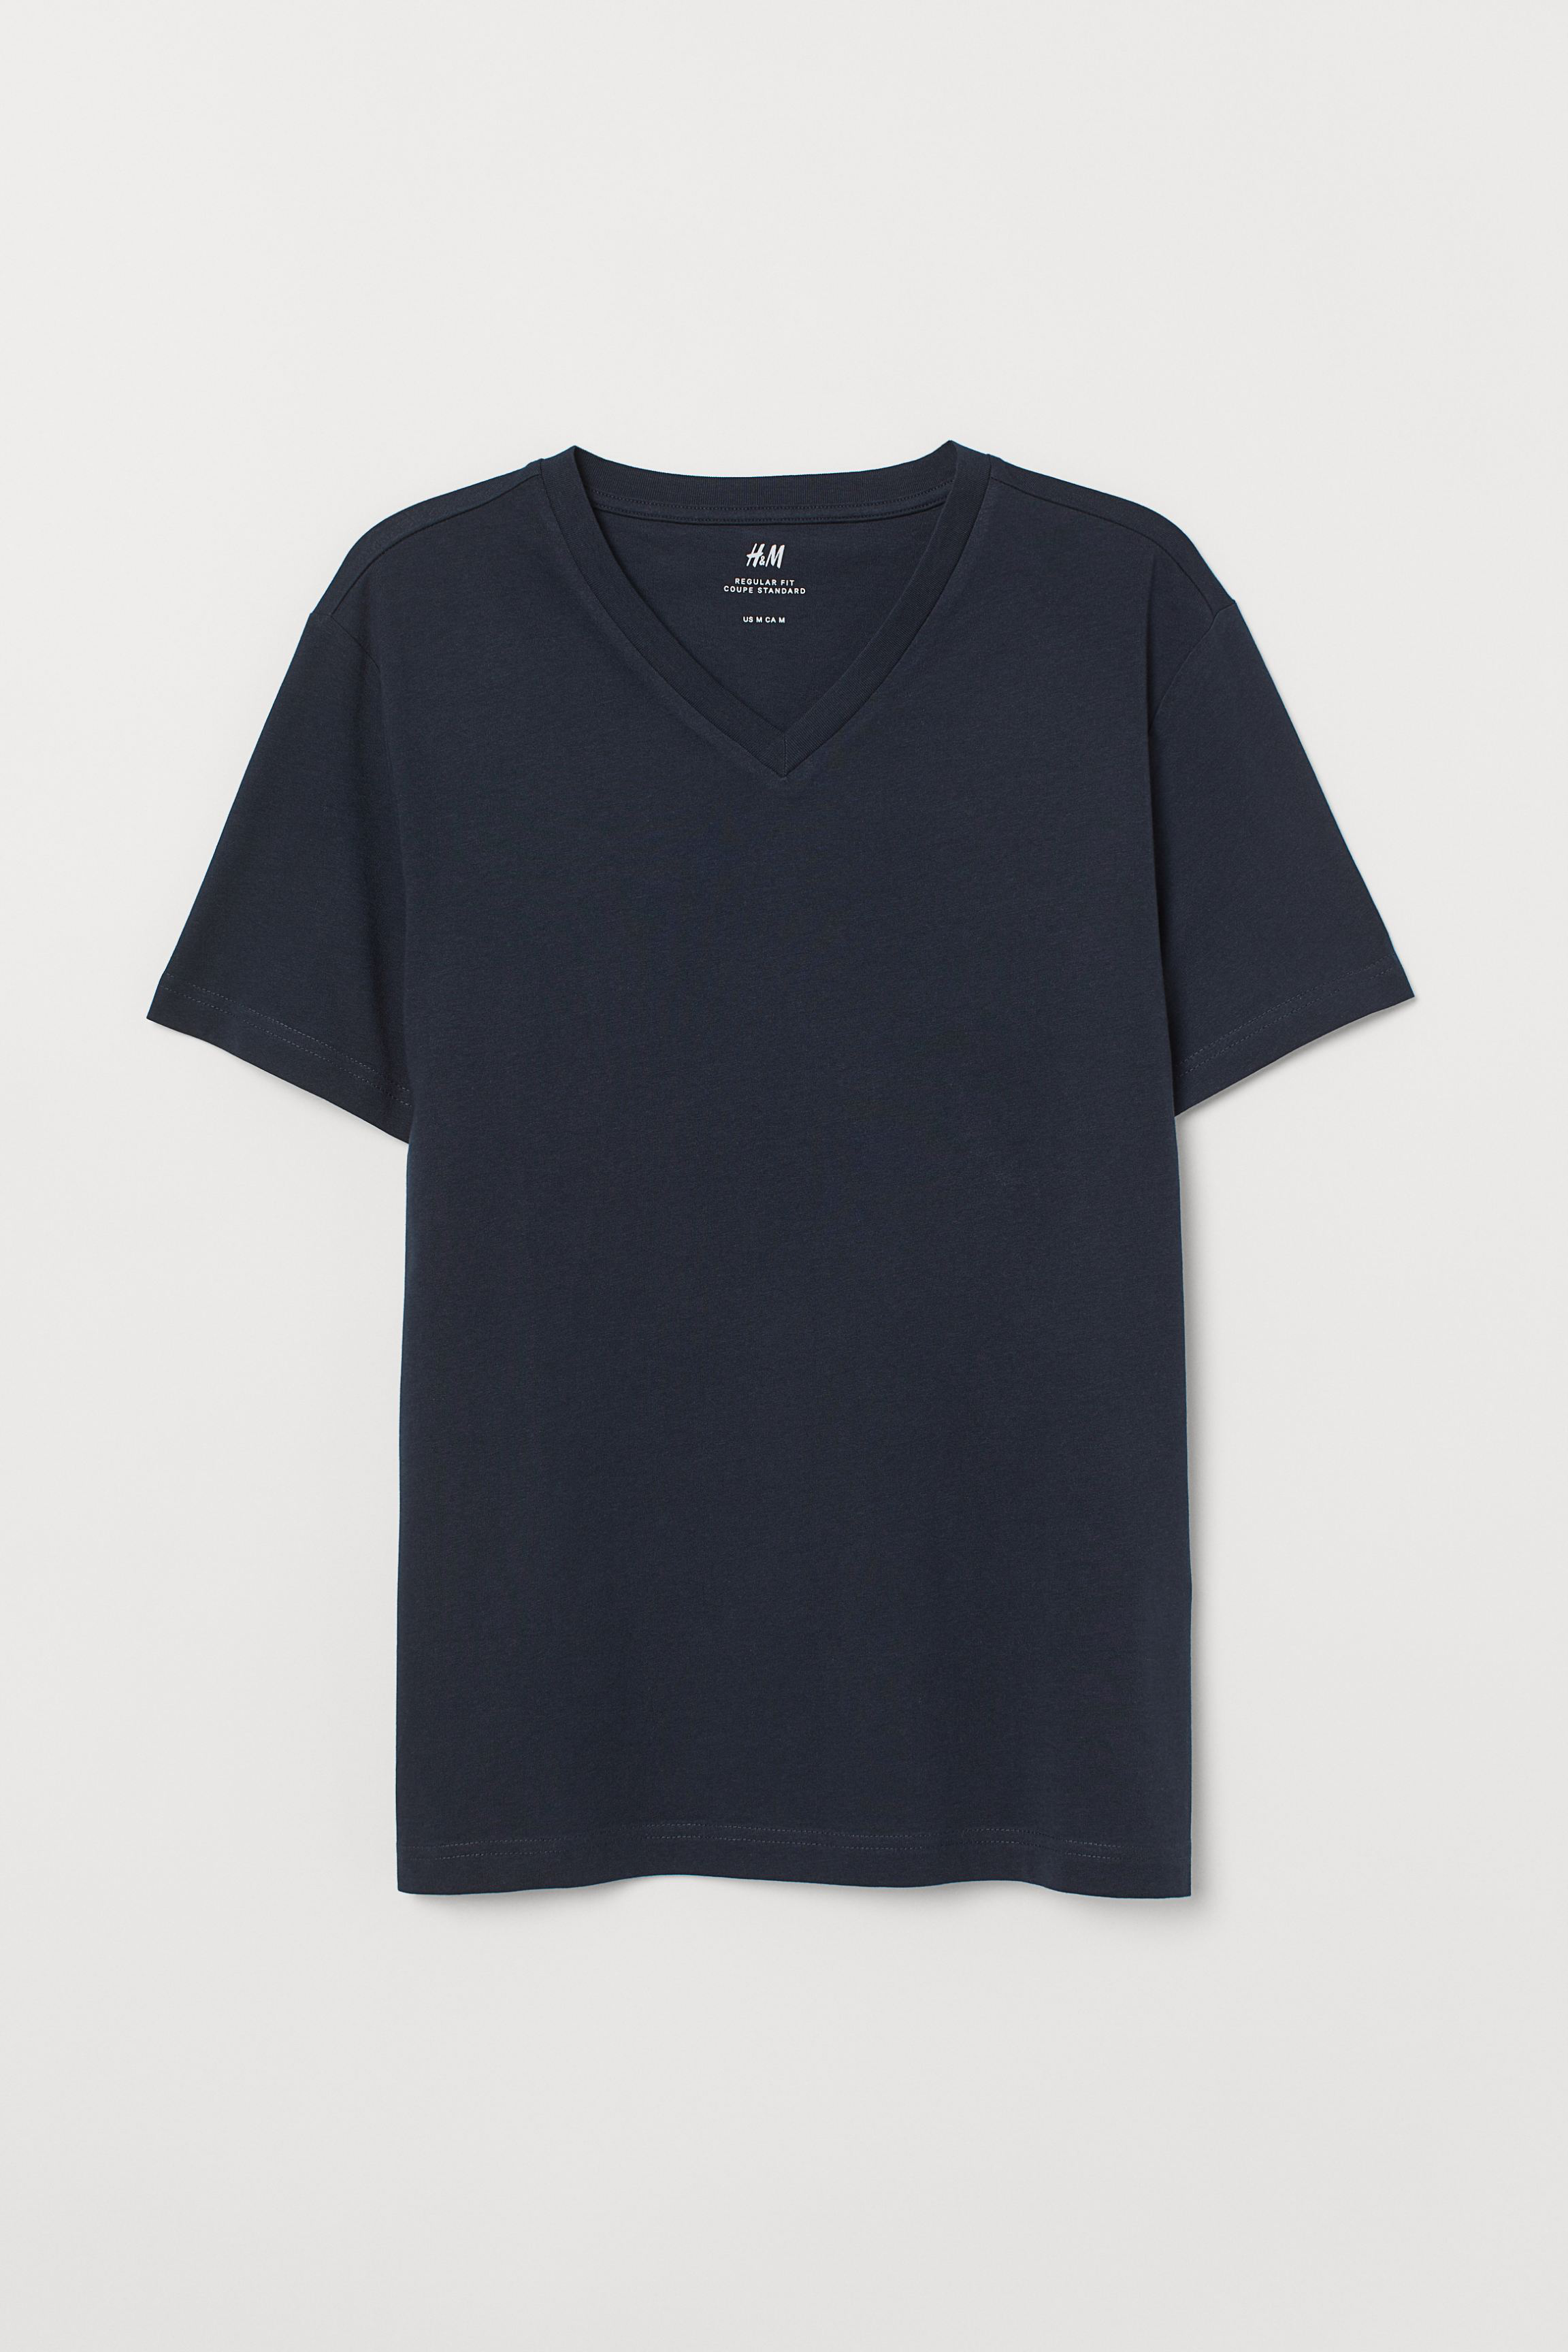

In [5]:
content_image = Image.open("/Users/rajdipingale/Downloads/Files/tf/W4A2/images/hmgoepprod.jpeg")
print("The content image (C) shows T shirt from H&M company.")
content_image

In [6]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
  
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))
    
 
    
    return J_content

<a name='4-2'></a>
### 4.2 - Computing the Style Cost

For the running example, you will use the following style image: 

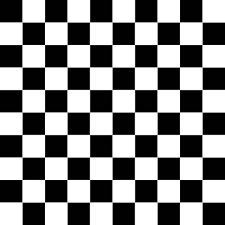

In [7]:
example = Image.open("/Users/rajdipingale/Downloads/Files/tf/W4A2/images/Checks.png")
example

In [8]:


def gram_matrix(A):
    
    GA = tf.matmul(A,tf.transpose(A))
    

    return GA

In [9]:


def compute_layer_style_cost(a_S, a_G):
   
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S,shape=[-1,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[-1,n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2))*(tf.reduce_sum(tf.square(tf.subtract(GS,GG)))))
   
    print(J_style_layer)
    
                     
    return J_style_layer

Start by listing the layer names:

In [10]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
#Content Layer
vgg.get_layer('block5_conv4').output

<KerasTensor shape=(None, 25, 25, 512), dtype=float32, sparse=False, name=keras_tensor_20>

Now choose layers to represent the style of the image and assign style costs:

In [13]:
STYLE_LAYERS = [
    ('block1_conv1', 0.1),
    ('block2_conv1', 0.1),
    ('block3_conv1', 0.1),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.5)]

In [14]:
### you cannot edit this cell

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
   
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [15]:

@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    
    J = alpha*J_content + beta*J_style
    

    return J

<a name='5'></a>
## 5 - Solving the Optimization Problem

Finally, you get to put everything together to implement Neural Style Transfer!


Here's what your program be able to do:

1. Load the content image 
2. Load the style image
3. Randomly initialize the image to be generated 
4. Load the VGG19 model
5. Compute the content cost
6. Compute the style cost
7. Compute the total cost
8. Define the optimizer and learning rate

Here are the individual steps in detail.

<a id='part(4)'></a>

<a name='5-1'></a>
###  Load the Content Image


(1, 400, 400, 3)


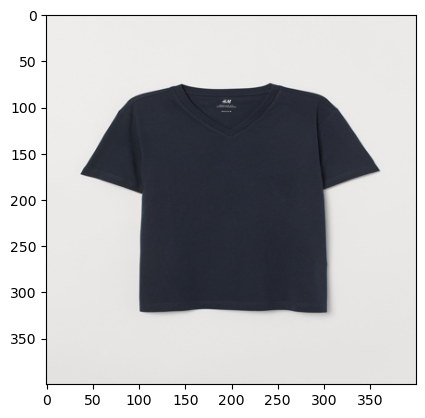

In [42]:
content_image = np.array(Image.open('/Users/rajdipingale/Downloads/hmgoepprod.jpg').resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
###  Load the Style Image


(1, 400, 400, 3)


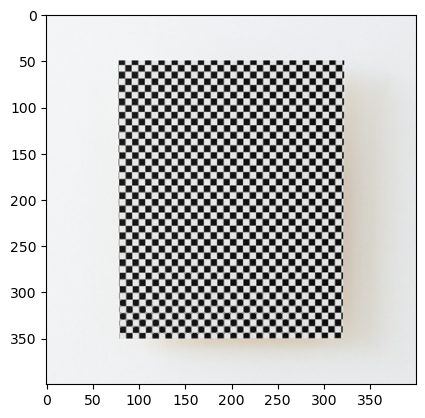

In [47]:
style_image =  np.array(Image.open("/Users/rajdipingale/Downloads/807344ee2c6d9fd203ec6a40b0d792bc.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### Randomly Initialize the Image to be Generated
 

(1, 400, 400, 3)


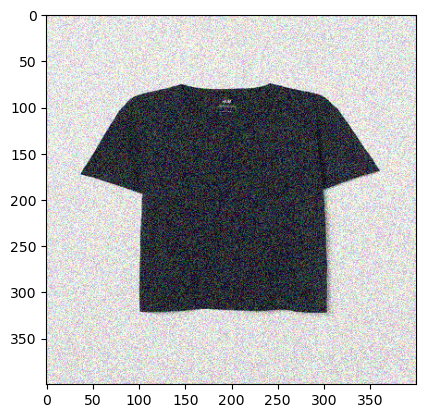

In [46]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## Load Pre-trained VGG19 Model


In [30]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    
    return model

Now, define the content layer and build the model.

In [31]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [48]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

<a name='5-5'></a>
###  - Compute Total Cost



In [49]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### - Compute the Style image Encoding (a_S) 



In [50]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that you will need to display the images generated by the style transfer model.

In [51]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='ex-6'></a>
###  - train_step 

In [55]:


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        
        a_G = vgg_model_outputs(generated_image)
        
        
        J_style = compute_style_cost(a_S,a_G)

        
        J_content = compute_content_cost(a_C,a_G)
        J = total_cost(J_content,J_style)
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
    # For grading purposes
    return J

Tensor("mul:0", shape=(), dtype=float32)
Tensor("mul_2:0", shape=(), dtype=float32)
Tensor("mul_4:0", shape=(), dtype=float32)
Tensor("mul_6:0", shape=(), dtype=float32)
Tensor("mul_8:0", shape=(), dtype=float32)
Tensor("mul:0", shape=(), dtype=float32)
Tensor("mul_2:0", shape=(), dtype=float32)
Tensor("mul_4:0", shape=(), dtype=float32)
Tensor("mul_6:0", shape=(), dtype=float32)
Tensor("mul_8:0", shape=(), dtype=float32)
Epoch 0, Loss: 9506.4013671875


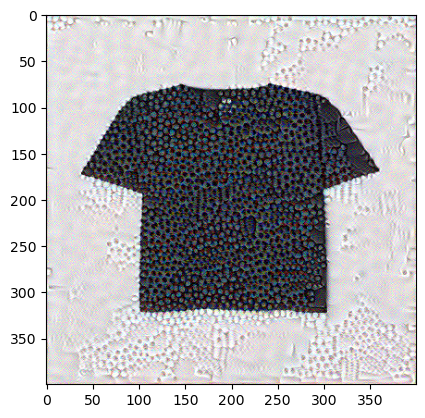

In [60]:

generated_image = tf.Variable(generated_image, dtype=tf.float32)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # Forward pass to get activations
        a_G = vgg_model_outputs(generated_image)
        
        # Compute style and content loss
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        
        # Total cost
        J = total_cost(J_content, J_style)
    
    # Compute gradients wrt generated_image
    grad = tape.gradient(J, generated_image)
    
    # Apply gradients to update the generated_image
    optimizer.apply_gradients([(grad, generated_image)])
    
    # Clip the pixel values of the image to be between 0 and 1
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 1.0))
    
    return J

# Training loop
epochs = 100
for i in range(epochs):
    # Perform one step of training
    J = train_step(generated_image)
    
    # Print every 250 epochs
    if i % 250 == 0:
        print(f"Epoch {i}, Loss: {J.numpy()}")
        
        # Convert tensor to image and display it
        image = tensor_to_image(generated_image)
        imshow(image)
        
        # Save the generated image
        image.save(f"output/image_{i}.jpg")
        
        # Show the image plot
        plt.show()


Now, run the following code cell to see the results!

Look at that! You did it! The `Generated image` on the right is the image you generated with the model. 

**Note 1:** These are the results of you training the model with a `learning_rate=0.01` (which was set in `Ex 6`) and ran it for `epochs = 2501` (set in `Section 5.6`). If you want to look at the in between results after every 250 epochs, click on `File --> Open...`. The go to `/output` directory to see all of the saved images.